In [1]:
import tensorflow as tf

from keras.layers import Dense, Flatten
from keras.losses import categorical_crossentropy


import numpy as np
import matplotlib.pyplot as plt
import json


from IPython import display
%matplotlib inline

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys
sys.path.append("../")
sys.path.append("../utils/")

In [3]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [4]:
def plot_pair(x,y):
    plt.figure(figsize=(s,s))
    f, (a1,a2) = plt.subplots(1, 2)
    
    a1.imshow(x)
    a2.imshow(y)
    plt.show()

In [5]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [20]:
synthetic_populations = np.load("../../data/simulation/35sp_1k/populations.npy")
y = np.load("../../data/simulation/35sp_1k/populations_gr.npy")
X = np.load("../../data/simulation/35sp_1k/amp_gr.npy")

params = json.load(open("../../data/simulation/35sp_1k/params.json", 'r'))

In [7]:
X.shape

(1000, 35, 35)

In [8]:
def norm(x):
    maxes = x.max(2)
    maxes[maxes == 0] = 1
    print(maxes.astype(int))
    return x / maxes.reshape(x.shape[0], x.shape[1], 1)

In [9]:
X[0].max(1)

array([  0., 486.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 328., 169.,
         0.,   0., 450.,   0.,  88.,   0.,   1.,   0.,   0., 492., 260.,
         0.,   0.,   0.,   0.,   0.,   0., 412., 694.,   0.,   0.,   0.,
         0., 378.])

In [22]:
X = norm(X)

[[  1 486   1 ...   1   1 378]
 [434  90 495 ...   1   2   1]
 [112   1 291 ...   1   1   1]
 ...
 [  1   1   1 ... 113   1 337]
 [  1   1 539 ... 493 354   1]
 [175   1   1 ... 399 397 280]]


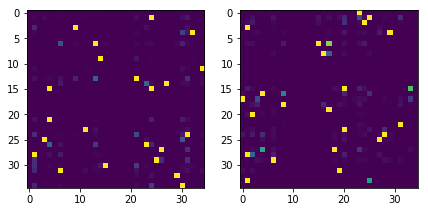

In [14]:
plot_group(X[3], 1, X[1], 1)

In [15]:
params

{'N_POPULATONS': 1000,
 'N_SPACERS': 35,
 'N_CHAINS': 6,
 'MAX_LEN': 13,
 'SWITCH_PROB': 0.05,
 'AMPLIFY_PROB': 0.35,
 'STOP_PROB': 0,
 'MAX_POPULATION_SIZE': 10000}

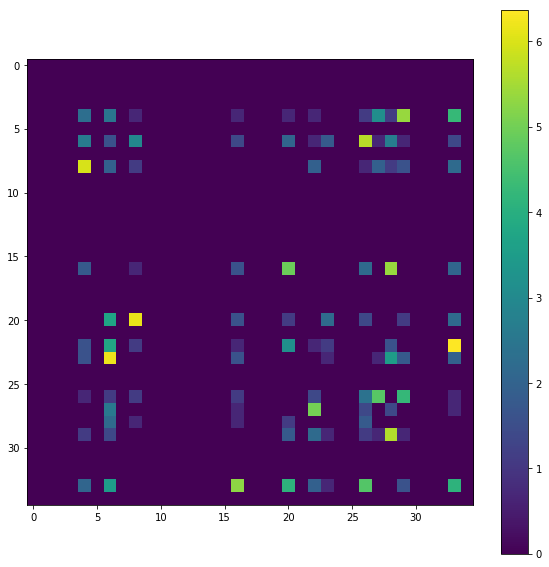

In [21]:
plot_gr(X[5], log = 1)

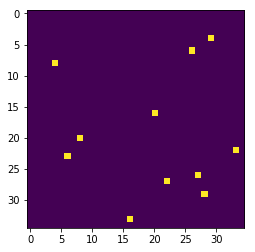

In [17]:
plt.imshow(y[5])

In [70]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [71]:
inp = tf.placeholder(tf.float32, [None, params["N_SPACERS"] * params["N_SPACERS"]])

#flatten = Flatten()(inp)
dense_1 = Dense(200, activation=tf.nn.relu)(inp)
dense_2 = Dense(200, activation=tf.nn.relu)(dense_1)

out = Dense(params["N_SPACERS"] * params["N_SPACERS"], activation=tf.nn.sigmoid)(dense_2)

In [72]:
target = tf.placeholder(tf.float32, [None, params["N_SPACERS"]* params["N_SPACERS"]])

In [73]:
loss = tf.reduce_mean(tf.losses.log_loss(target, out, weights=target*35 + 1))
#loss = tf.reduce_mean(tf.losses.mean_squared_error(target, out) * (target * 10 + 1))

In [74]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)

In [75]:

#sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [76]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [77]:
sess.run(loss, feed_dict = {inp : X[:50].reshape(-1, 35 * 35), target : y[:50].reshape(-1, 35 * 35)})

0.96118504

In [78]:
losses_each_n = []
val_losses = []
val_x = []
n = 10
curr_loss = 0


In [79]:
epochs = 100

In [80]:
def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt].reshape(-1,params["N_SPACERS"] * params["N_SPACERS"]) , y[excerpt].reshape(-1,params["N_SPACERS"] * params["N_SPACERS"])

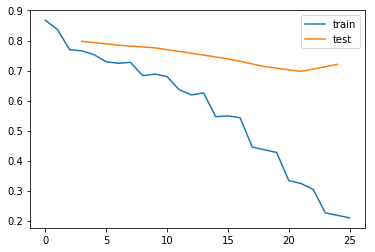

KeyboardInterrupt: 

In [81]:
for epoch in range(epochs):
    for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X[:800], y[:800], 20)):

        batch_loss = sess.run([train_step,loss], feed_dict={inp : batch_X, target: batch_y})
        curr_loss += batch_loss[1]

        if i % n == 0:
            if i != 0:
                losses_each_n.append( curr_loss / n)
            
            curr_loss = 0


            display.clear_output(wait=True)
            plt.plot(losses_each_n[1:], label='train')
            plt.plot(val_x, val_losses, label='test')
            plt.legend()
            plt.show()
            
    val_loss = sess.run(loss,  feed_dict={inp : X[800:].reshape(-1, 35 * 35), target: y[800:].reshape(-1, 35 * 35)})
    val_losses.append(val_loss)
    val_x.append(len(losses_each_n))
    
    curr_loss == 0

        #print(batch_loss[1])

In [94]:
gr = np.load("../../data/graphs/ES3_22.npy")[:35,:35]

In [56]:
gr.max(1).astype(int)

array([ 9224, 17455,  4956,  3815,  8568,  2941,  3022,  3059,  2268,
        1809,  1174,     2,  1845,  1067,  1432,   619,     2,  1019,
         102,   289,    86,    77,    69,    69,    18,    30,    38,
          52,    42,     1,    42,    24,    24,    14,     0])

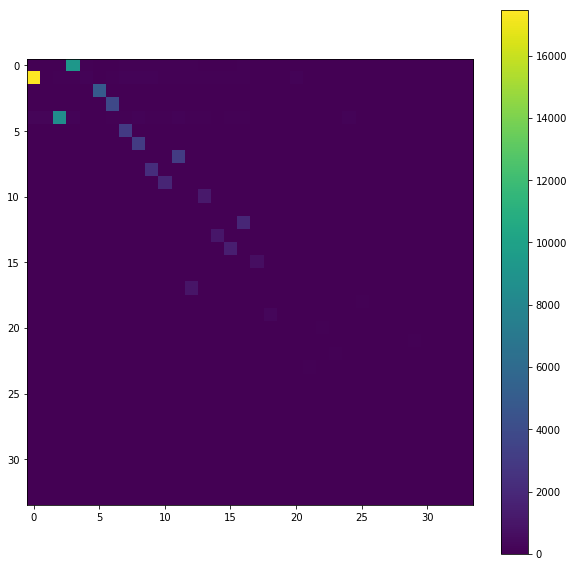

In [51]:
plot_gr(gr)

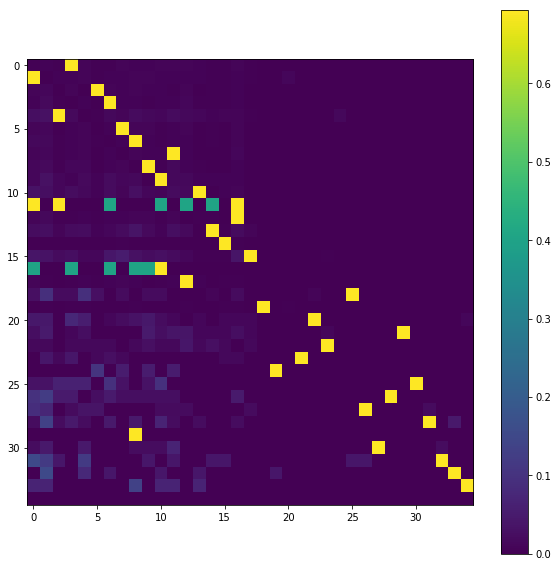

In [60]:
plot_gr(gr_n, log = 1)

In [59]:
#gr_n = gr / gr.max(1).reshape(-1,1)
gr_n[-1] = 0

In [82]:
gr_out = sess.run(out, feed_dict = {inp : gr_n.reshape(-1,35 * 35)}).reshape(35,35)

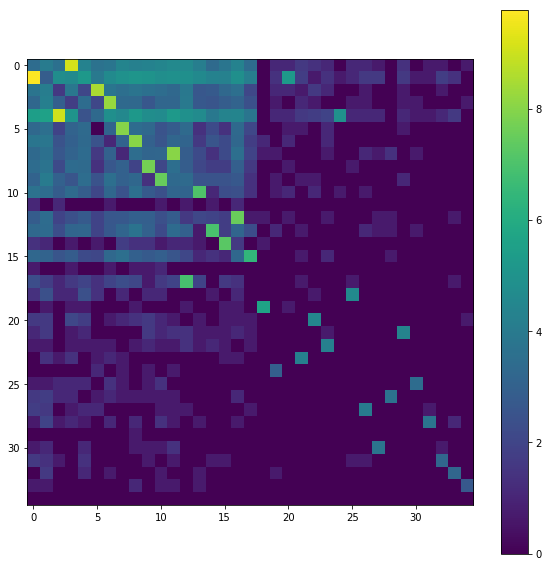

In [98]:
plot_gr(gr.astype(int), log = 1)

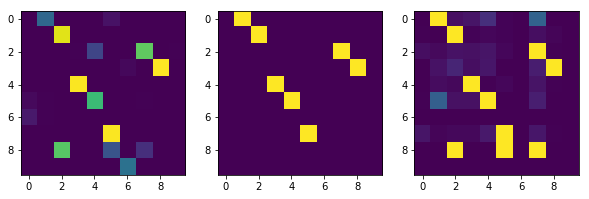

In [338]:
ind = 800

gr = sess.run(out, feed_dict = {inp : np.hstack((X, X_emb[:,:5]))[ind].reshape(-1,150)}).reshape(10,10)
plot_group(gr , 0, y[ind], 0,  X[ind], 1, s = 10)

In [330]:
gr = sess.run(out, feed_dict = {inp : np.hstack((X, X_emb[:,:5]))[800:].reshape(-1,150)}).reshape(200, 10,10)

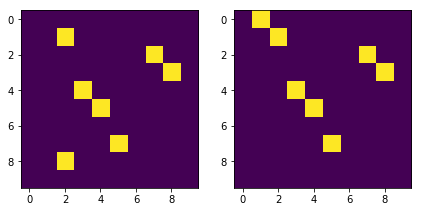

In [331]:
plot_group(gr[0] > 0.5, 0, y[800], 0)

In [250]:
from sklearn.metrics import log_loss, accuracy_score

In [334]:
loss = 0
for i in range(200):
    loss += accuracy_score(y[i + 800], gr[i] > 0.5)

In [335]:
loss / 200

0.8290000000000015

## Node2vec

In [20]:
sys.path.append("../")

In [263]:
import main as n2v
import node2vec as n2v_src
import networkx as nx

In [272]:
from importlib import reload
n2v = reload(n2v)
n2v_src = reload(n2v_src)

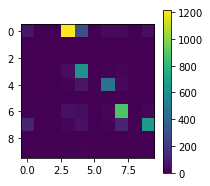

In [29]:
plot_gr(X[11], s =3)

In [269]:
def gr_to_nxGr(graph):
    nxG = nx.DiGraph()
    for i in range(graph.shape[0]):
        for j in range(graph.shape[1]):
            nxG.add_edge(i, j, weight = graph[i,j])
    return nxG

In [99]:
def gr_to_emb(graph):
    spacers_num = graph.shape[0]
    
    nx_gr = gr_to_nxGr(graph)
    G = n2v_src.Graph(nx_gr, 1, 0.5, 0.5)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(200, spacers_num)
    model = n2v.learn_embeddings(walks, spacers_num, 5, 4, 100)
    
    E = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        E[i] = model.wv.word_vec(str(i))
    pca = PCA(n_components=spacers_num)
    
    return pca.fit_transform(E), walks

In [287]:
emb, walks = gr_to_emb(X[2])

In [290]:
X_emb = np.zeros_like(X)

In [291]:
from tqdm import tqdm_notebook

In [295]:
for i, x in enumerate(tqdm_notebook(X)):
    emb, walks = gr_to_emb(x)
    X_emb[i] = emb

A Jupyter Widget

../node2vec/src/node2vec.py:87: RuntimeWarning: invalid value encountered in double_scalars
  normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
../node2vec/src/node2vec.py:72: RuntimeWarning: invalid value encountered in double_scalars
  normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]


In [296]:
np.save("../../data/simulation/simple1k/embs", X_emb)

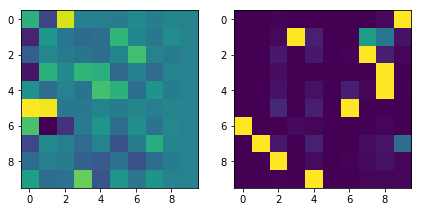

In [288]:
plot_group(emb, 0, X[2], 0)

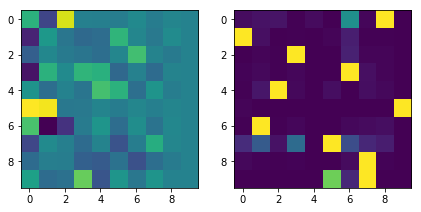

In [289]:
plot_group(emb, 0, X[1], 0)

In [103]:
from sklearn.decomposition import PCA

In [104]:
pca = PCA(n_components=2)

In [105]:
pca.fit_transform(E)

array([[-1.04583212,  0.44248204],
       [ 1.13473591,  0.04076436],
       [ 1.27760196,  0.00648308],
       [-0.85260869, -0.25610945],
       [-0.77946134,  0.16066381],
       [ 1.2406656 ,  0.09062604],
       [-0.77474962, -0.2514189 ],
       [-0.70512859, -0.28424838],
       [ 1.20216892, -0.0827374 ],
       [-0.69739203,  0.13349479]])

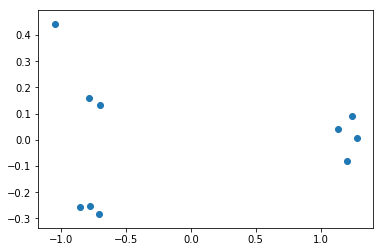

In [106]:
plt.scatter(pca.fit_transform(E)[:,0], pca.fit_transform(E)[:, 1])

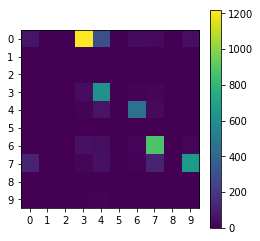

In [84]:
plot_gr(gr, s=4,all_ticks=1)

In [81]:
from gensim.models import Word2Vec

In [52]:
Word2Vec()

[[8, 0, 3, 4, 6, 7, 9, 4, 6, 7, 9, 7, 7, 7, 9, 7, 9, 4, 7, 9],
 [2, 0, 3, 4, 6, 7, 0, 3, 3, 4, 4, 6, 7, 9, 7, 9, 4, 9, 4, 6],
 [6, 7, 9, 4, 6, 7, 9, 4, 4, 4, 6, 7, 9, 7, 0, 7, 9, 4, 6, 7],
 [1, 0, 3, 4, 0, 3, 4, 6, 7, 7, 9, 7, 9, 4, 6, 7, 9, 3, 4, 4],
 [3, 4, 6, 7, 9, 4, 4, 6, 7, 7, 9, 4, 4, 6, 7, 0, 3, 4, 6, 7],
 [7, 0, 3, 3, 4, 6, 7, 9, 4, 6, 7, 0, 3, 4, 4, 4, 6, 7, 0, 6],
 [5, 0, 3, 4, 6, 7, 0, 3, 4, 6, 7, 9, 7, 9, 4, 6, 3, 4, 6, 7],
 [4, 6, 7, 9, 4, 6, 3, 4, 6, 7, 9, 4, 6, 7, 9, 4, 6, 7, 9, 7],
 [0, 3, 4, 3, 4, 6, 7, 7, 9, 7, 9, 4, 6, 7, 9, 4, 7, 7, 9, 7],
 [9, 7, 9, 4, 6, 4, 6, 6, 0, 3, 4, 6, 7, 9, 7, 9, 3, 4, 6, 7],
 [9, 4, 6, 7, 9, 4, 6, 7, 9, 7, 9, 7, 9, 3, 4, 6, 3, 4, 6, 7],
 [0, 4, 6, 3, 4, 6, 7, 9, 7, 0, 3, 3, 4, 6, 7, 9, 4, 6, 7, 0],
 [1, 0, 3, 4, 6, 7, 7, 7, 7, 0, 4, 6, 0, 3, 4, 4, 6, 7, 9, 7],
 [6, 7, 9, 4, 6, 7, 9, 4, 6, 7, 9, 4, 6, 7, 9, 3, 4, 6, 7, 3],
 [4, 6, 7, 9, 4, 6, 7, 0, 3, 4, 6, 7, 9, 4, 6, 7, 9, 4, 6, 7],
 [5, 0, 3, 3, 4, 6, 7, 9, 7, 9, 7, 9, 4, 7, 9, 7, 9, 4,